## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Latihan Project/hr-analytics-attrition/data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

## Preprocessing

In [ ]:
print("Nilai unik Attrition:", df['Attrition'].unique())

Nilai unik Attrition: ['Yes' 'No']


In [ ]:
constant_cols = df.nunique()[df.nunique() == 1].index.tolist()
print("Fitur konstan yang akan dihapus:", constant_cols)

Fitur konstan yang akan dihapus: ['EmployeeCount', 'Over18', 'StandardHours']


In [ ]:
num_df = df.select_dtypes(include=np.number)
corr_matrix = num_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]
print("Fitur dengan korelasi tinggi yang akan dihapus:", high_corr_cols)

Fitur dengan korelasi tinggi yang akan dihapus: ['MonthlyIncome']


In [ ]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nDistribusi {col}:\n{df[col].value_counts(normalize=True)}")

print("\nNilai unik JobLevel:", df['JobLevel'].unique())


Distribusi Attrition:
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

Distribusi BusinessTravel:
BusinessTravel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: proportion, dtype: float64

Distribusi Department:
Department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: proportion, dtype: float64

Distribusi EducationField:
EducationField
Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: proportion, dtype: float64

Distribusi Gender:
Gender
Male      0.6
Female    0.4
Name: proportion, dtype: float64

Distribusi JobRole:
JobRole
Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manage

In [ ]:
drop_cols = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'] + high_corr_cols + constant_cols
drop_cols = list(set(drop_cols))
print("\nKolom yang akan di-drop:", drop_cols)
df.drop(drop_cols, axis=1, inplace=True)


Kolom yang akan di-drop: ['MonthlyIncome', 'EmployeeNumber', 'StandardHours', 'EmployeeCount', 'Over18']


In [ ]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [ ]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['OverTime'] = df['OverTime'].map({'No': 0, 'Yes': 1})

In [ ]:
df = pd.get_dummies(df, columns=[
    'BusinessTravel', 'Department', 'EducationField',
    'JobRole', 'MaritalStatus'
], drop_first=True)

In [ ]:
# Feature engineering
df['YearsInSameRoleRatio'] = df['YearsInCurrentRole'] / (df['TotalWorkingYears'] + 1)
df['YearsWithManagerRatio'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
df['PromotionGap'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']

In [ ]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling

### Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_log = logreg.predict(X_test_scaled)
y_proba_log = logreg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print("=== Logistic Regression ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))

=== Logistic Regression ===
Confusion Matrix:
[[358  12]
 [ 44  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       370
           1       0.69      0.38      0.49        71

    accuracy                           0.87       441
   macro avg       0.79      0.67      0.71       441
weighted avg       0.86      0.87      0.86       441

ROC-AUC: 0.8228778073848495


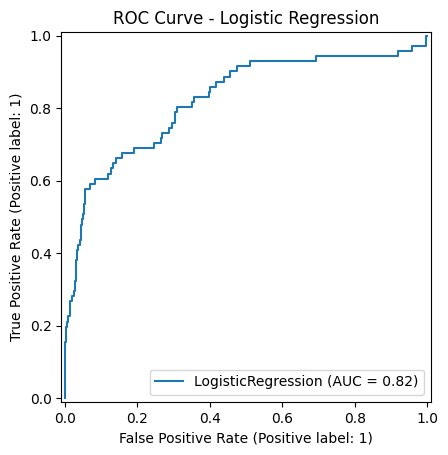

In [ ]:
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [ ]:
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Top fitur (Logistic Regression):")
print(coeff_df.head(10))

Top fitur (Logistic Regression):
                             Feature  Coefficient
12                          OverTime     0.889203
17                 TotalWorkingYears    -0.699394
39           JobRole_Sales Executive     0.683334
34     JobRole_Laboratory Technician     0.659943
24  BusinessTravel_Travel_Frequently     0.659868
40      JobRole_Sales Representative     0.588857
44             YearsWithManagerRatio    -0.561539
23              YearsWithCurrManager     0.503560
11                NumCompaniesWorked     0.501904
4            EnvironmentSatisfaction    -0.458589


### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # tanpa scaling

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
print("=== Random Forest ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

=== Random Forest ===
Confusion Matrix:
[[360  10]
 [ 60  11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       370
           1       0.52      0.15      0.24        71

    accuracy                           0.84       441
   macro avg       0.69      0.56      0.58       441
weighted avg       0.80      0.84      0.80       441

ROC-AUC: 0.7670346402740768


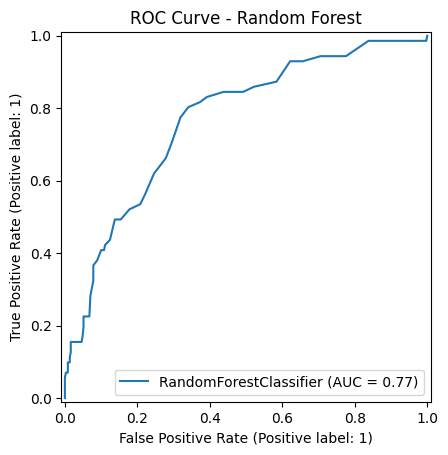

In [ ]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [ ]:
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top fitur (Random Forest):")
print(importances_df.head(10))


Top fitur (Random Forest):
                  Feature  Importance
0                     Age    0.069264
17      TotalWorkingYears    0.059249
1               DailyRate    0.052421
6              HourlyRate    0.047049
10            MonthlyRate    0.045240
2        DistanceFromHome    0.044953
44  YearsWithManagerRatio    0.039342
11     NumCompaniesWorked    0.038588
12               OverTime    0.033783
23   YearsWithCurrManager    0.033490
